In [1]:
# Import modules
# ipython magic to plot in line
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib
#matplotlib.style.use('ggplot')
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from astropy.io import ascii
import sklearn.metrics as skm
import pytz
import scipy
# OS interaction
import sys
import os
import glob
import time
plt.rcParams.update({'figure.max_open_warning': 0})
import fnmatch

In [2]:
# Dirs
# IN
survey_dir  = os.path.normpath(r'C:\Users\new356\Google Drive\Nov2014 Data QC Completed Data\Snow Surveys\Fortress_snow survey data 2013_2016')

# OUT
out_dir     = os.path.normpath(r'F:\Work\e\Data\Obs\Canada_Project_Sites\Nov_2014_snow_storm_data\QC_netcdf')
cfileout    = os.path.join(out_dir,'CRHO_Snow_Survey_Individual.nc')

In [3]:
year_dir = ['2013 - 2014','2014 - 2015','2015 - 2016']

In [4]:
# function that gets dataframe for a single snow survey
def get_sheet_data(cdf):
    
    import re
    def solve(s):                                             
        return re.sub(r'(\d)(st|nd|rd|th)', r'\1', s)
    
    # Get date of snow survey
    cdate = cdf.columns[1]
#     print(cdate)
    if isinstance(cdate,str):
        try:
            survey_date = datetime.datetime.strptime(solve(cdate),'%B %d, %Y')
        except:
            survey_date = datetime.datetime.strptime(solve(cdate),'%b %d, %Y')
    else:
        survey_date = cdate
    print(survey_date)

    # Find header row
    header_row = cdf.loc[cdf['Date'] == 'Point '].index.values[0]

    # Save new column names
    col_names = cdf.iloc[header_row]
#     print(col_names)

    # Trim comments at top
    cdf_trim_1 = cdf.iloc[header_row:-1]

    # Find Start and stop of data
    I_nan = cdf_trim_1[cdf_trim_1['Date'].isnull()].index.values # Get first and last Nan (we want data between)
    I_S = I_nan[0] + 1
    I_E = I_nan[1] - 1

    # Trim to single point measurements
    cdf_trim_2 = cdf_trim_1.loc[I_S:I_E]
    # Set new column names
    cdf_trim_2.columns = col_names
    # Remove empty space
    cdf_trim_3 = cdf_trim_2.rename(columns=lambda x: x.strip())
    # Reset index to Point
    cdf_trim_3.set_index('Point',inplace=True)
    
    # Drop non float columns
    del cdf_trim_3['Notes']
    
    # Cast to floats
    cdf_trim_4 = cdf_trim_3.astype('float')
    
    # Make into a dataSet
    ds = xr.Dataset.from_dataframe(cdf_trim_4)
    # Add time
    ds['time'] = survey_date
    
    return ds

In [5]:
# For each year
year_list = []
for cyear in year_dir:
    
#     # Move to current year folder
#     os.chdir(os.path.join(survey_dir,cyear)

    # Find all files
    matches = []
    for root, dirnames, filenames in os.walk(os.path.join(survey_dir,cyear)):
        for filename in fnmatch.filter(filenames, '*.xlsx'):
            matches.append(os.path.join(root, filename))
    print(matches)

    # For each transect
    tran_dict = []
    for cfile in matches:
        print(cfile)

        # Get all sheets as dict of dataframes
        df_dict = pd.read_excel(cfile,sheetname=None,na_values='')
        # Drop sheet called graph
        if 'graphs' in df_dict:     
            del df_dict['graphs']
        if 'Graphs' in df_dict:     
            del df_dict['Graphs']
        if 'SPA' in df_dict:
            del df_dict['SPA']
        if 'Sommer' in df_dict:
            del df_dict['Sommer']
        if 'Sheet2' in df_dict:
            del df_dict['Sheet2']

        # Get survey days (sheet names)
        days = np.sort(list(df_dict.keys()))
#         print(days)
        # For each survey day
        data_dict = []
        for cday in days:
            data_dict.append(get_sheet_data(df_dict[cday]))

        # Combine by time
        ds_all_1 = xr.concat(data_dict,dim='time')
        # Sort time dim by well time
        ds_all = ds_all_1.isel(time=np.argsort(ds_all_1.time))
        # Set transect
        ds_all['transect'] = os.path.splitext(os.path.basename(cfile))[0].replace(' ','')

        # Store in list
        tran_dict.append(ds_all)

    # Combine by transect
    ds_tran = xr.concat(tran_dict,dim='transect')
    year_list.append(ds_tran)
                                             

['C:\\Users\\new356\\Google Drive\\Nov2014 Data QC Completed Data\\Snow Surveys\\Fortress_snow survey data 2013_2016\\2013 - 2014\\Bonsai Clearing.xlsx', 'C:\\Users\\new356\\Google Drive\\Nov2014 Data QC Completed Data\\Snow Surveys\\Fortress_snow survey data 2013_2016\\2013 - 2014\\Canadian Ridge.xlsx', 'C:\\Users\\new356\\Google Drive\\Nov2014 Data QC Completed Data\\Snow Surveys\\Fortress_snow survey data 2013_2016\\2013 - 2014\\Fortress Ridge South.xlsx', 'C:\\Users\\new356\\Google Drive\\Nov2014 Data QC Completed Data\\Snow Surveys\\Fortress_snow survey data 2013_2016\\2013 - 2014\\Fortress Ridge.xlsx', 'C:\\Users\\new356\\Google Drive\\Nov2014 Data QC Completed Data\\Snow Surveys\\Fortress_snow survey data 2013_2016\\2013 - 2014\\Powerline.xlsx']
C:\Users\new356\Google Drive\Nov2014 Data QC Completed Data\Snow Surveys\Fortress_snow survey data 2013_2016\2013 - 2014\Bonsai Clearing.xlsx
2014-04-25 00:00:00
2014-04-08 00:00:00
2014-02-25 00:00:00
2014-06-11 00:00:00
2014-06-27 00:0

In [6]:
# Combine by time (over years)
ds_all = xr.concat(year_list,dim='time')
ds_all.transect

<xarray.DataArray 'transect' (transect: 6)>
array(['BonsaiClearing', 'CanadianRidge', 'CanadianRidgenew', 'FortressRidge',
       'FortressRidgeSouth', 'Powerline'], dtype=object)
Coordinates:
  * transect  (transect) object 'BonsaiClearing' 'CanadianRidge' ...

In [7]:
# Add stations (matching transect order)
station = ['BNS','none','CRN','FRG','FRS','none']
ds_all['station'] = xr.DataArray(station, coords={'transect': ds_all.transect}, dims=('transect'))

In [8]:
ds_all.set_coords('station',inplace=True)

<xarray.Dataset>
Dimensions:                   (Point: 33, time: 39, transect: 6)
Coordinates:
  * Point                     (Point) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * transect                  (transect) object 'BonsaiClearing' ...
  * time                      (time) datetime64[ns] 2014-01-07 2014-02-25 ...
    station                   (transect) <U4 'BNS' 'none' 'CRN' 'FRG' 'FRS' ...
Data variables:
    Depth                     (transect, time, Point) float64 nan nan nan ...
    Tare                      (transect, time, Point) float64 nan nan nan ...
    SWE                       (transect, time, Point) float64 nan nan nan ...
    Density                   (transect, time, Point) float64 nan nan nan ...
    SWE (using mean density)  (transect, time, Point) float64 nan nan nan ...
    SWE (using regression)    (transect, time, Point) float64 nan nan nan ...

In [9]:
## Calculate SWE values

# SWE contains the Tar weight, so subtract it
ds_all['SWE'] = ds_all.SWE - ds_all.Tare
ds_all = ds_all.drop('Tare')

In [10]:
ds_all.rename({'SWE (using mean density)':'SWEmeanDen','SWE (using regression)':'SWEregrDen'},inplace=True)
ds_all

<xarray.Dataset>
Dimensions:     (Point: 33, time: 39, transect: 6)
Coordinates:
  * Point       (Point) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * transect    (transect) object 'BonsaiClearing' 'CanadianRidge' ...
  * time        (time) datetime64[ns] 2014-01-07 2014-02-25 2014-02-26 ...
    station     (transect) <U4 'BNS' 'none' 'CRN' 'FRG' 'FRS' 'none'
Data variables:
    Depth       (transect, time, Point) float64 nan nan nan nan nan nan nan ...
    SWE         (transect, time, Point) float64 nan nan nan nan nan nan nan ...
    Density     (transect, time, Point) float64 nan nan nan nan nan nan nan ...
    SWEmeanDen  (transect, time, Point) float64 nan nan nan nan nan nan nan ...
    SWEregrDen  (transect, time, Point) float64 nan nan nan nan nan nan nan ...

In [11]:
# Units to meteric standard
ds_all['Depth'] = ds_all['Depth']/100 # cm to m
ds_all['SWE'] = ds_all['SWE']/100 # cm to m
ds_all['SWEmeanDen'] = ds_all['SWEmeanDen']/1000 # mm to m
ds_all['SWEregrDen'] = ds_all['SWEregrDen']/1000 # mm to m

In [12]:
# Save to netcdf file
ds_all.to_netcdf(cfileout,engine='netcdf4')

In [13]:
# Plot settings
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.5})

<xarray.DataArray 'Depth' (time: 39, Point: 33)>
array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 1.54,  1.6 ,  1.63, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ..., 
       [ 0.41,  0.59,  0.56, ...,   nan,   nan,   nan],
       [ 0.  ,  0.  ,  0.  , ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])
Coordinates:
  * Point     (Point) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    transect  <U14 'BonsaiClearing'
  * time      (time) datetime64[ns] 2014-01-07 2014-02-25 2014-02-26 ...
    station   <U3 'BNS'


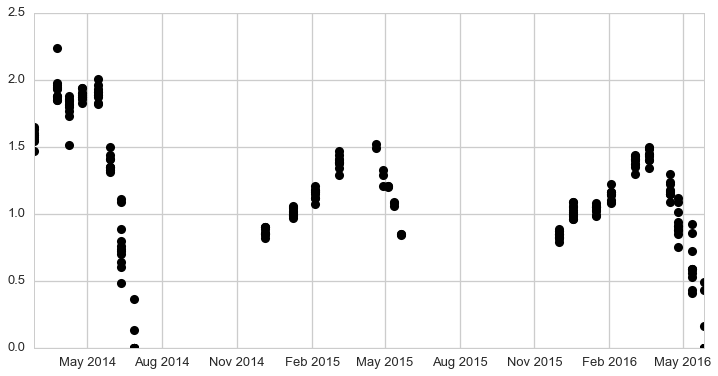

In [14]:
# Example of selecting transect by station name
csta ='BNS'
I_tran = ds_all.station==csta
co = ds_all['Depth'].sel(transect=I_tran).squeeze()
print(co)
(f, ax1) = plt.subplots(1, 1)
f.set_size_inches(12, 6)
plt.plot(co.time,co,'ko')


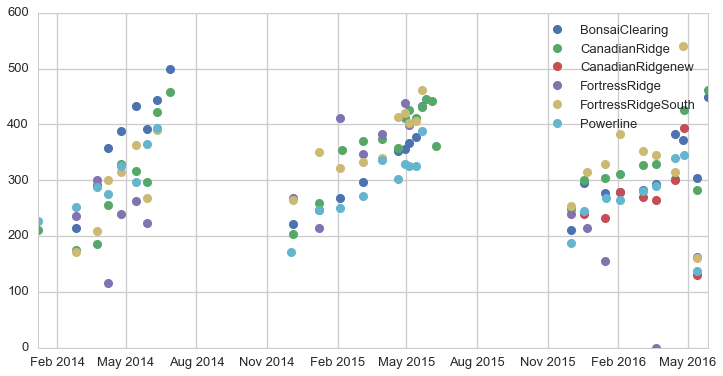

In [15]:
# Plot
(f, ax1) = plt.subplots(1, 1)
f.set_size_inches(12, 6)
plt.plot(ds_all.time,ds_all['Density'].mean(dim='Point').T,'o')
plt.legend(ds_all.transect.values)

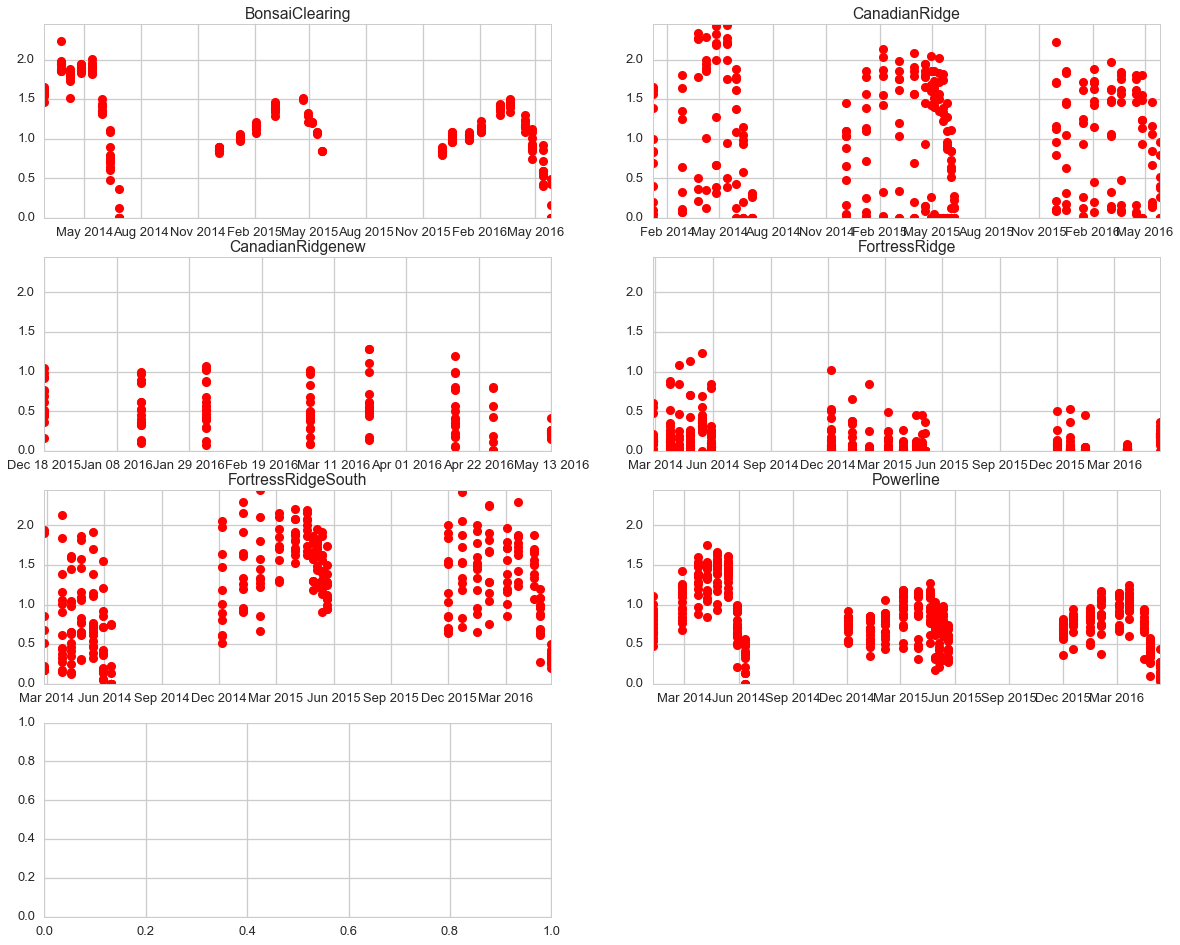

In [17]:
## With snow survey data
cvar = 'Depth'
# Create a new figure and subplots for each variable
(f, ax1) = plt.subplots(4, 2,)
ax1 = ax1.reshape(-1)
f.set_size_inches(20, 16)
sel_stations = ds_all.transect
v_c = 0
for csta in sel_stations:

    tran_obs = ds_all[cvar].sel(transect=csta).squeeze()
#         hto = tran_obs.plot.line(color='b',marker='o',ax=ax1[v_c],label='Observed:Survey')
    hto = ax1[v_c].plot(tran_obs.time,tran_obs,'ro')
    
    # Clean up plot
    ax1[v_c].set_ylim([0,np.max(ds_all[cvar].max().values)])
#     ax1[v_c].set_xlim([DS,DE])
    ax1[v_c].set_title(csta.values)
    v_c += 1
ax1[-1].set_axis_off()